## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import math
import glob
import os

## Import Data

In [2]:
# Read in the data
path = 'Data/'
files_transactions = ["Data/property_transactions_batch_1.csv",
                    "Data/property_transactions_batch_2.csv",
                    "Data/property_transactions_batch_3.csv",
                    "Data/property_transactions_batch_4.csv"]
# files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]

df = pd.concat((pd.read_csv(file) for file in files_transactions), ignore_index=True)
df.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,y,floorRange,area,street,contractDate,typeOfArea
0,1,Freehold,RCR,3,5,NaN,20914.198897,Strata Terrace,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,-,186.0,NEO PEE TECK LANE,321,Strata
1,1,Freehold,RCR,3,5,NaN,20914.198897,Terrace,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,-,257.0,NEO PEE TECK LANE,522,Land
2,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5200000,LANDED HOUSING DEVELOPMENT,NaN,-,308.0,ZEHNDER ROAD,921,Land
3,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5188888,LANDED HOUSING DEVELOPMENT,NaN,-,228.4,ZEHNDER ROAD,724,Land
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,Apartment,2065000,AUREA,NaN,21-25,66.0,BEACH ROAD,925,Strata


In [3]:
# Remove duplicates
df_raw = df.copy()
df = df.drop_duplicates()

In [4]:
df['contractYear'] = df['contractDate'].apply(lambda x: x % 100 + 2000)
df['contractMonth'] = df['contractDate'].apply(lambda x: x // 100)

In [5]:
df['tenure'] = df['tenure'].str.lower()     # Convert to lowercase for consistency
df['tenureDuration'] = df['tenure'].apply(lambda x: np.inf if 'freehold' in str(x) else int(x.split(' ')[0]) if isinstance(x, str) and len(x.split(' ')) > 1 else np.nan)      # If 'freehold' then 0, if NaN then NaN
df['tenureStartYear'] = df['tenure'].apply(lambda x: int(x.split(' ')[-1]) if isinstance(x, str) and len(x.split(' ')) > 3 else np.nan)     # If 'freehold' or '99 years lease' then nan
df['tenureRemaining'] = df.apply(lambda x: np.inf if 'freehold' in str(x['tenure']) else (x['tenureDuration'] - (x['contractYear'] - x['tenureStartYear'])) if not pd.isna(x['tenureStartYear']) else np.nan, axis=1)

In [6]:
df = df.dropna(subset=["price", "contractDate"])
df.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
0,1,freehold,RCR,3,5,NaN,20914.198897,Strata Terrace,1880000,LANDED HOUSING DEVELOPMENT,...,-,186.0,NEO PEE TECK LANE,321,Strata,2021,3,inf,NaN,inf
1,1,freehold,RCR,3,5,NaN,20914.198897,Terrace,4600000,LANDED HOUSING DEVELOPMENT,...,-,257.0,NEO PEE TECK LANE,522,Land,2022,5,inf,NaN,inf
2,1,freehold,RCR,3,5,NaN,NaN,Semi-detached,5200000,LANDED HOUSING DEVELOPMENT,...,-,308.0,ZEHNDER ROAD,921,Land,2021,9,inf,NaN,inf
3,1,freehold,RCR,3,5,NaN,NaN,Semi-detached,5188888,LANDED HOUSING DEVELOPMENT,...,-,228.4,ZEHNDER ROAD,724,Land,2024,7,inf,NaN,inf
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,Apartment,2065000,AUREA,...,21-25,66.0,BEACH ROAD,925,Strata,2025,9,99.0,2024.0,98.0


# By PropertyType

In [45]:
# Similar properties sold more than once
df_all = df.copy()
group_cols = ["project", "street", "district", "area", "x", "y", "typeOfArea", "propertyType", 'tenureStartYear']

df_all = df_all.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
df_all = (
    df_all.groupby(group_cols+["contractYear"])
    .agg(
        mean_price=("price", "mean"),
        transaction_count=("price", "count")
    )
    .reset_index()
)


# Take the average price to 2 decimal places
df_all["mean_price"] = df_all["mean_price"].round(2)

In [46]:
# Normalize prices to per square foot
df_all['price_psm'] = df_all['mean_price'] / df_all['area']
df_all['price_psm'] = df_all['price_psm'].round(2)
df_all.head()

,project,street,district,area,x,y,typeOfArea,propertyType,tenureStartYear,contractYear,mean_price,transaction_count,price_psm
0,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,2020,840000.00,1,9655.17
1,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,2021,884962.67,3,10171.98
2,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,2023,1109000.00,2,12747.13
3,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,2025,1230000.00,1,14137.93
4,1 CANBERRA,CANBERRA DRIVE,27,88.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,2020,873571.43,7,9926.95


In [47]:
df_all = (
    df_all.groupby(["propertyType", "contractYear"])
      .apply(lambda g: pd.Series({
          "weighted_price_psm": np.average(g["price_psm"], weights=g["transaction_count"]),
          "total_transactions": g["transaction_count"].sum()
      }))
      .reset_index()
      .sort_values(["propertyType", "contractYear"])
)

df_all.head()

C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\34328395.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,propertyType,contractYear,weighted_price_psm,total_transactions
0,Apartment,2020,17856.837171,2061.0
1,Apartment,2021,20215.497208,9484.0
2,Apartment,2022,20968.999752,5841.0
3,Apartment,2023,20561.569404,3440.0
4,Apartment,2024,20254.569787,3481.0


In [48]:
df_all["pct_change"] = (
    df_all.groupby("propertyType")["weighted_price_psm"].pct_change()
)
df_all["log_return"] = (
    df_all.groupby("propertyType")["weighted_price_psm"]
    .transform(lambda x: np.log(x / x.shift(1)))
)

df_all.head()

,propertyType,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,Apartment,2020,17856.837171,2061.0,NaN,NaN
1,Apartment,2021,20215.497208,9484.0,0.132087,0.124063
2,Apartment,2022,20968.999752,5841.0,0.037274,0.036596
3,Apartment,2023,20561.569404,3440.0,-0.019430,-0.019621
4,Apartment,2024,20254.569787,3481.0,-0.014931,-0.015043


In [49]:
property_types = df_all["propertyType"].unique()
n_types = len(property_types)

# Define grid layout: 3 columns
ncols = 3
nrows = math.ceil(n_types / ncols)

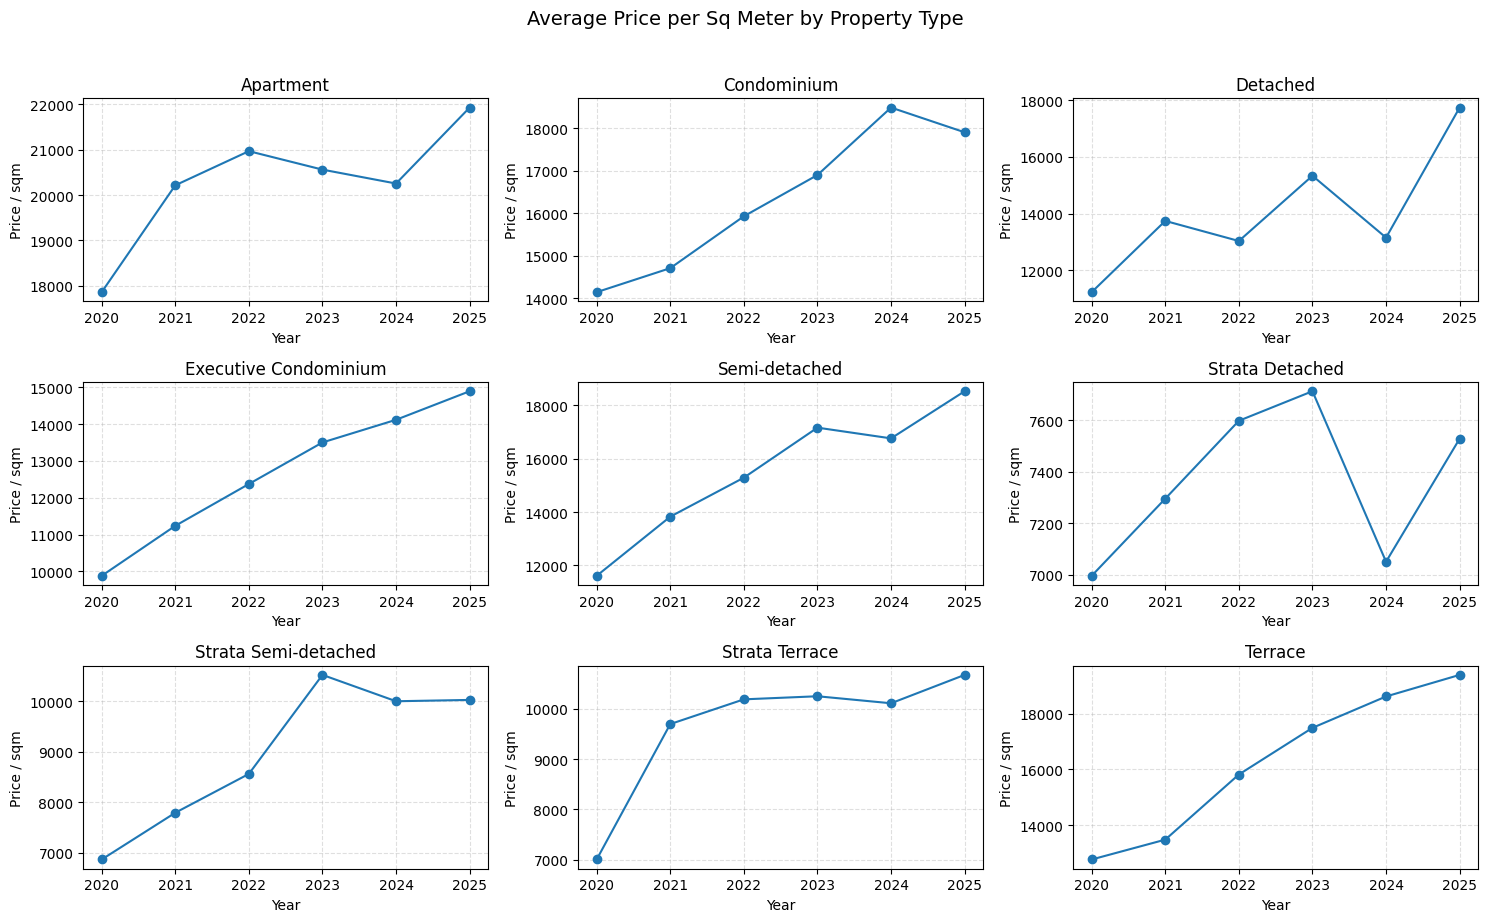

In [50]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_all[df_all["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["weighted_price_psm"], marker="o", lw=1.5)
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))  # every 1 year
    ax.set_ylabel("Price / sqm")
    ax.grid(True, linestyle="--", alpha=0.4)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Average Price per Sq Meter by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Returns in CCR

In [13]:
# Similar properties sold more than once
df_ccr = df[df['marketSegment']=='CCR']
group_cols = ["project", "street", "district", "area", "x", "y", "typeOfArea", "propertyType", 'tenureStartYear']

df_ccr = df_ccr.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
df_ccr = (
    df_ccr.groupby(group_cols+["contractYear"])
    .agg(
        mean_price=("price", "mean"),
        transaction_count=("price", "count")
    )
    .reset_index()
)

# Take the average price to 2 decimal places
df_ccr["mean_price"] = df_ccr["mean_price"].round(2)

In [14]:
# Normalize prices to per square foot
df_ccr['price_psm'] = df_ccr['mean_price'] / df_ccr['area']
df_ccr['price_psm'] = df_ccr['price_psm'].round(2)
df_ccr.head()

,project,street,district,area,x,y,typeOfArea,propertyType,tenureStartYear,contractYear,mean_price,transaction_count,price_psm
0,19 NASSIM,NASSIM HILL,10,50.0,26665.60779,32098.67077,Strata,Apartment,2019.0,2023,2086200.0,1,41724.00
1,19 NASSIM,NASSIM HILL,10,50.0,26665.60779,32098.67077,Strata,Apartment,2019.0,2025,2000000.0,1,40000.00
2,19 NASSIM,NASSIM HILL,10,53.0,26665.60779,32098.67077,Strata,Apartment,2019.0,2024,2047093.0,1,38624.40
3,19 NASSIM,NASSIM HILL,10,53.0,26665.60779,32098.67077,Strata,Apartment,2019.0,2025,2169090.0,1,40926.23
4,19 NASSIM,NASSIM HILL,10,60.0,26665.60779,32098.67077,Strata,Apartment,2019.0,2024,1979835.0,3,32997.25


In [15]:
df_ccr = (
    df_ccr.groupby(["propertyType", "contractYear"])
      .apply(lambda g: pd.Series({
          "weighted_price_psm": np.average(g["price_psm"], weights=g["transaction_count"]),
          "total_transactions": g["transaction_count"].sum()
      }))
      .reset_index()
      .sort_values(["propertyType", "contractYear"])
)

df_ccr.head()

C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\253175949.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,propertyType,contractYear,weighted_price_psm,total_transactions
0,Apartment,2020,22998.032270,163.0
1,Apartment,2021,26486.463139,1787.0
2,Apartment,2022,26509.226306,896.0
3,Apartment,2023,26536.696456,711.0
4,Apartment,2024,25233.337441,555.0


In [16]:
df_ccr["pct_change"] = (
    df_ccr.groupby("propertyType")["weighted_price_psm"].pct_change()
)
df_ccr["log_return"] = (
    df_ccr.groupby("propertyType")["weighted_price_psm"]
    .transform(lambda x: np.log(x / x.shift(1)))
)

df_ccr.head()

,propertyType,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,Apartment,2020,22998.032270,163.0,NaN,NaN
1,Apartment,2021,26486.463139,1787.0,0.151684,0.141225
2,Apartment,2022,26509.226306,896.0,0.000859,0.000859
3,Apartment,2023,26536.696456,711.0,0.001036,0.001036
4,Apartment,2024,25233.337441,555.0,-0.049115,-0.050363


In [17]:
property_types = df_ccr["propertyType"].unique()
n_types = len(property_types)

# Define grid layout: 3 columns
ncols = 3
nrows = math.ceil(n_types / ncols)

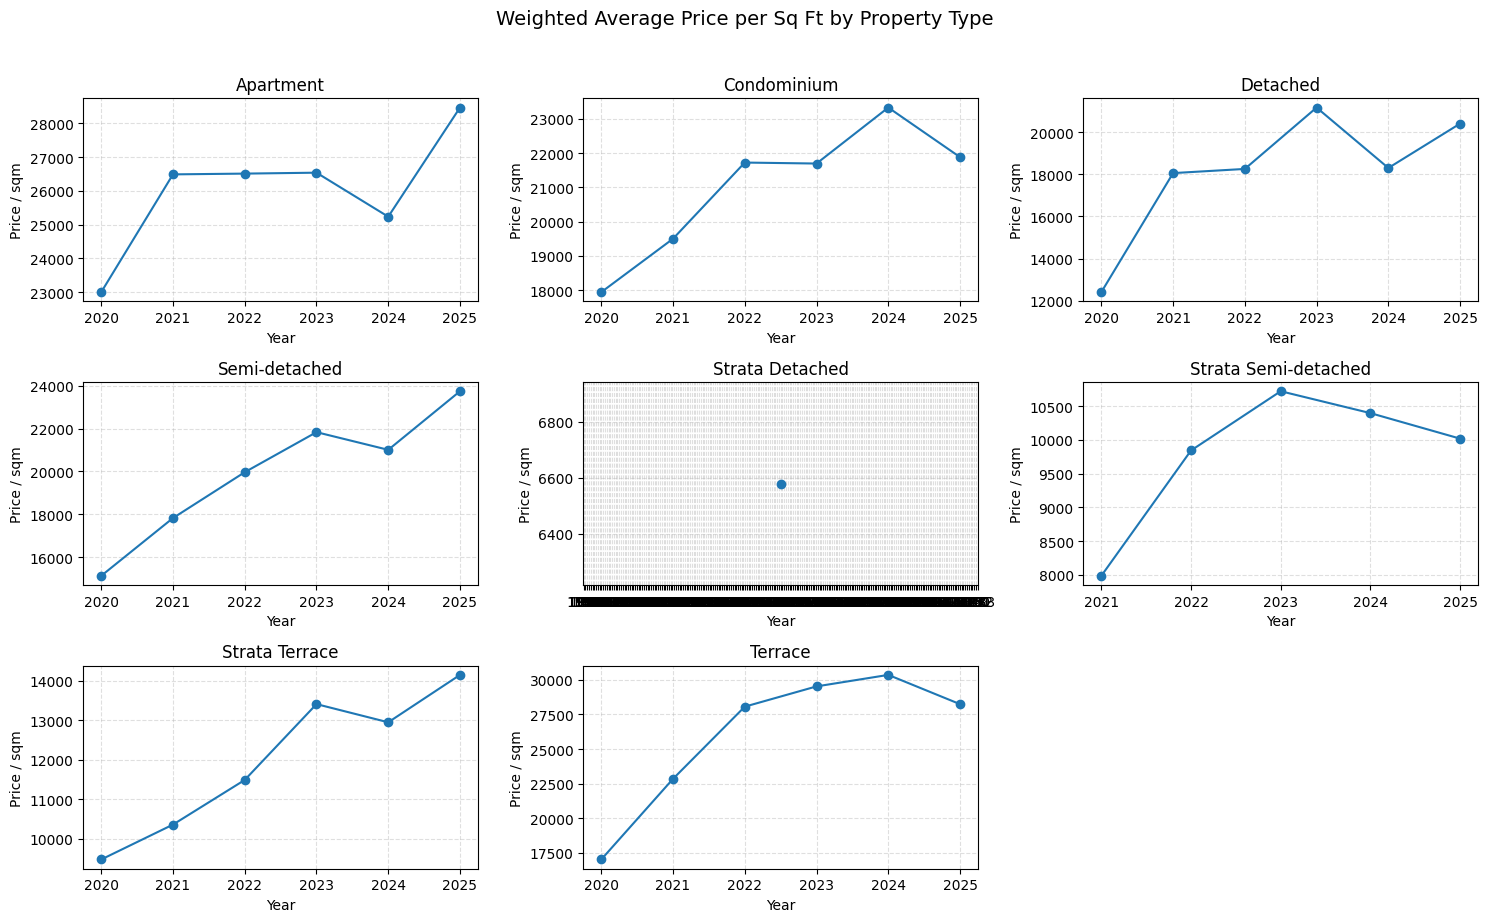

In [18]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_ccr[df_ccr["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["weighted_price_psm"], marker="o", lw=1.5)
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))  # every 1 year
    ax.set_ylabel("Price / sqm")
    ax.grid(True, linestyle="--", alpha=0.4)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Weighted Average Price per Sq Ft by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

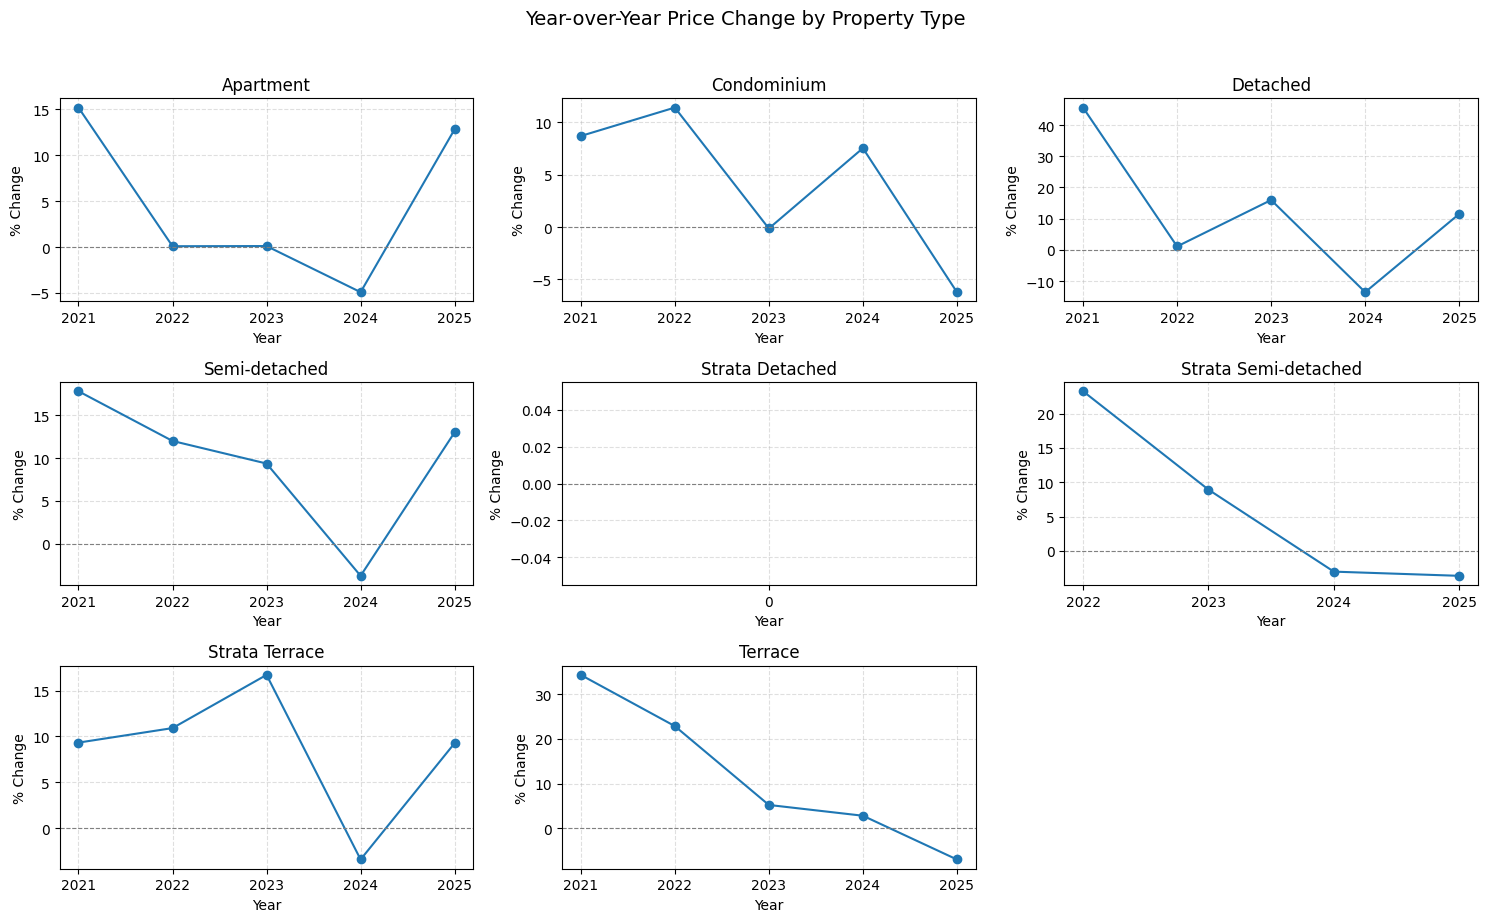

In [19]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_ccr[df_ccr["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["pct_change"] * 100, marker="o", lw=1.5)
    ax.axhline(0, color="gray", lw=0.8, linestyle="--")
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.set_ylabel("% Change")
    ax.grid(True, linestyle="--", alpha=0.4)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year-over-Year Price Change by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Returns in RCR

In [20]:
# Similar properties sold more than once
df_rcr = df[df['marketSegment']=='RCR']
group_cols = ["project", "street", "district", "area", "x", "y", "typeOfArea", "propertyType", 'tenureStartYear']

df_rcr = df_rcr.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
df_rcr = (
    df_rcr.groupby(group_cols+["contractYear"])
    .agg(
        mean_price=("price", "mean"),
        transaction_count=("price", "count")
    )
    .reset_index()
)

# Take the average price to 2 decimal places
df_rcr["mean_price"] = df_rcr["mean_price"].round(2)

# Normalize prices to per square foot
df_rcr['price_psm'] = df_rcr['mean_price'] / df_rcr['area']
df_rcr['price_psm'] = df_rcr['price_psm'].round(2)
df_rcr.head()

df_rcr = (
    df_rcr.groupby(["propertyType", "contractYear"])
      .apply(lambda g: pd.Series({
          "weighted_price_psm": np.average(g["price_psm"], weights=g["transaction_count"]),
          "total_transactions": g["transaction_count"].sum()
      }))
      .reset_index()
      .sort_values(["propertyType", "contractYear"])
)

df_rcr["pct_change"] = (
    df_rcr.groupby("propertyType")["weighted_price_psm"].pct_change()
)
df_rcr["log_return"] = (
    df_rcr.groupby("propertyType")["weighted_price_psm"]
    .transform(lambda x: np.log(x / x.shift(1)))
)


C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\2682183064.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [21]:
property_types = df_rcr["propertyType"].unique()
n_types = len(property_types)

# Define grid layout: 3 columns
ncols = 3
nrows = math.ceil(n_types / ncols)

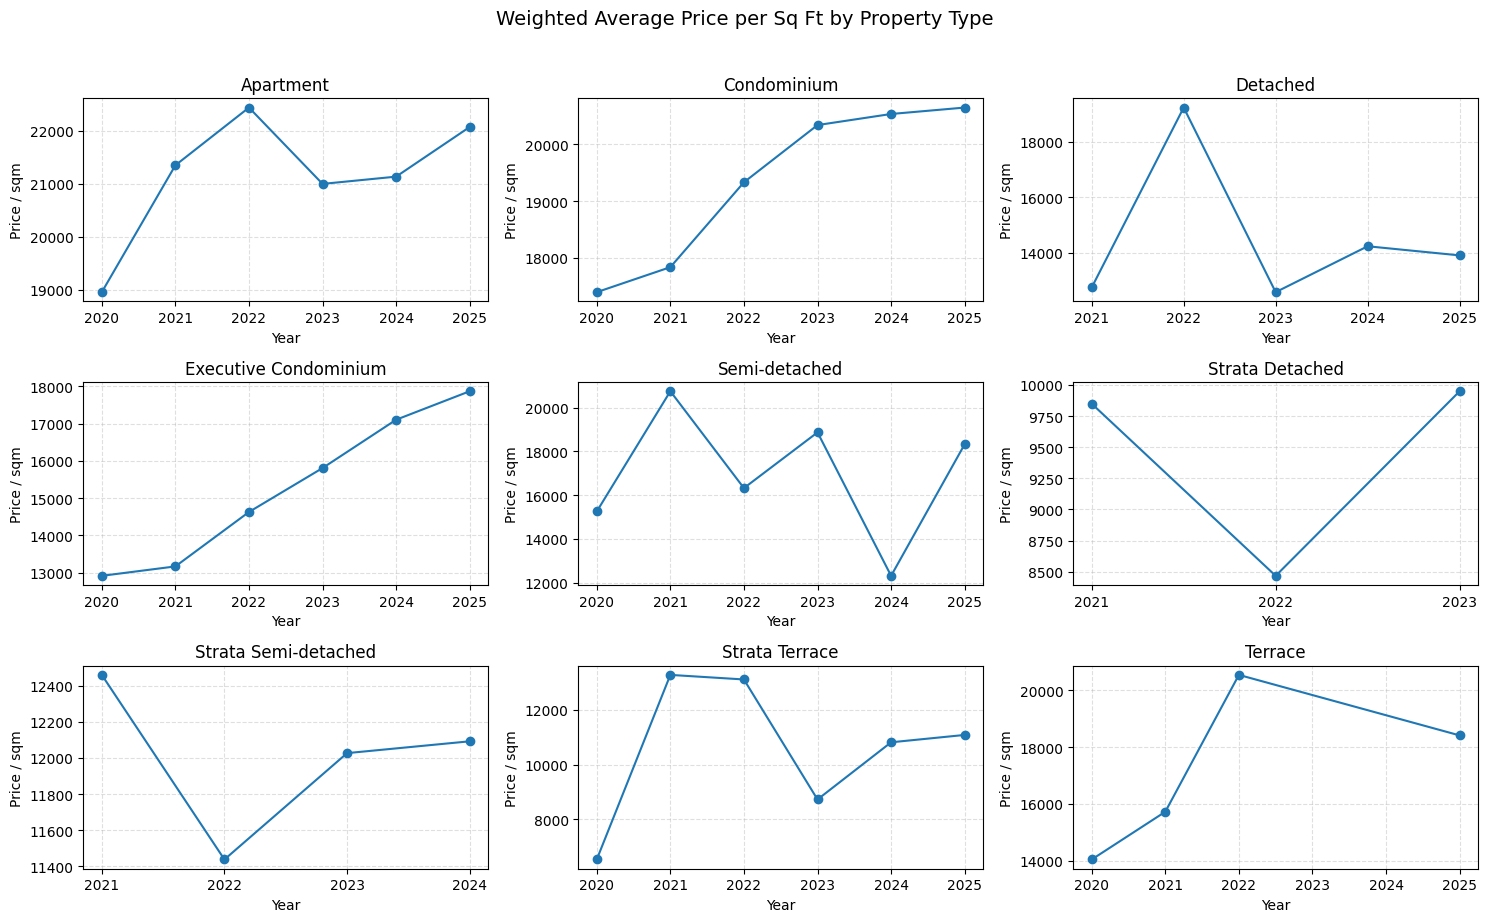

In [22]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_rcr[df_rcr["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["weighted_price_psm"], marker="o", lw=1.5)
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))  # every 1 year
    ax.set_ylabel("Price / sqm")
    ax.grid(True, linestyle="--", alpha=0.4)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Weighted Average Price per Sq Ft by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

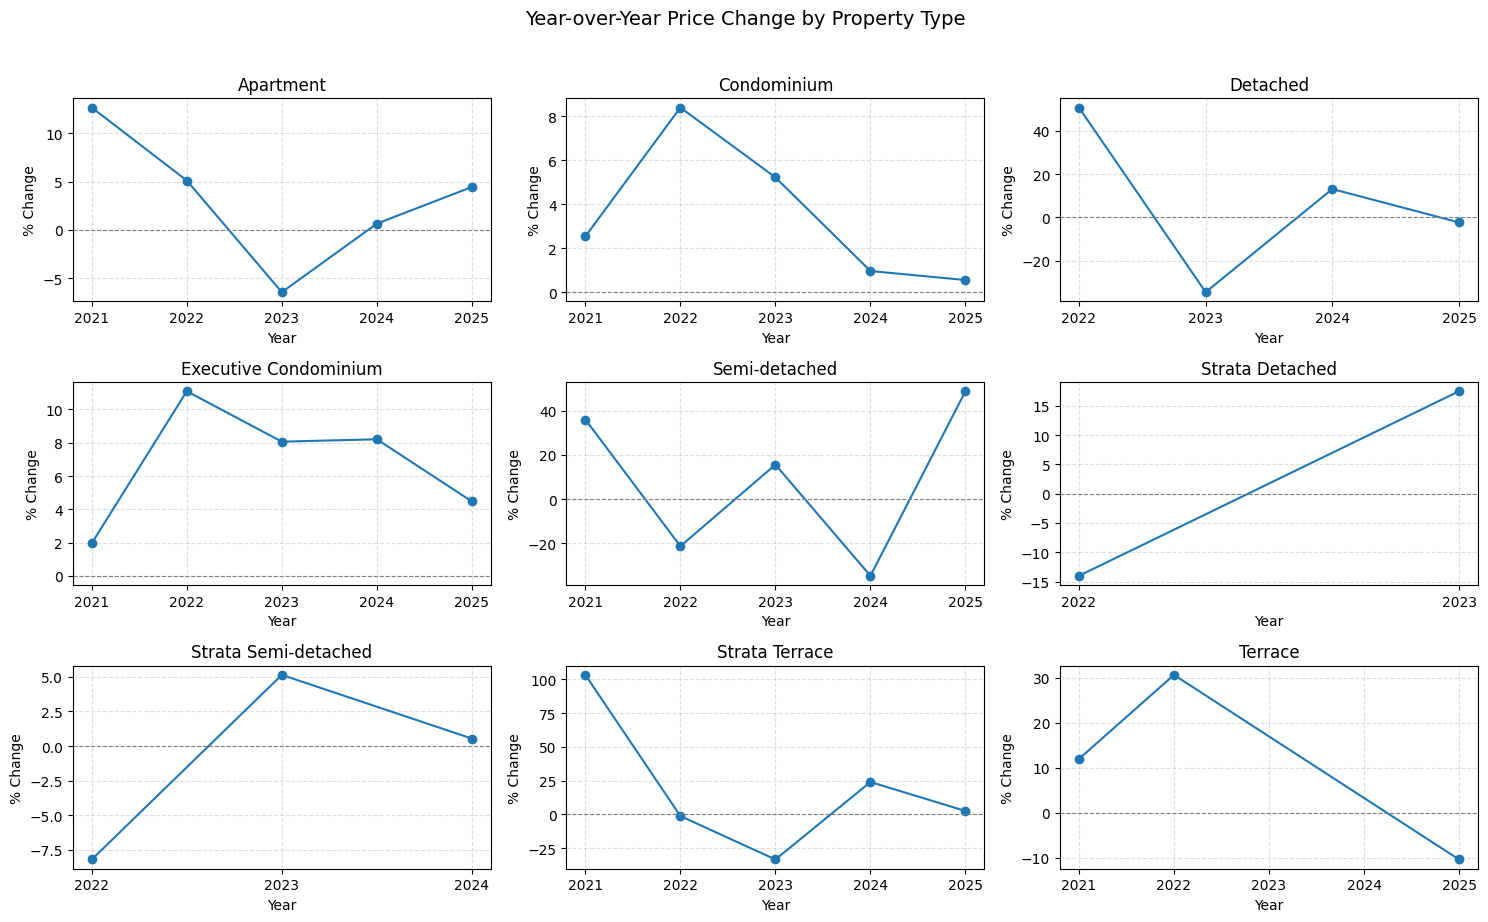

In [23]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_rcr[df_rcr["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["pct_change"] * 100, marker="o", lw=1.5)
    ax.axhline(0, color="gray", lw=0.8, linestyle="--")
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.set_ylabel("% Change")
    ax.grid(True, linestyle="--", alpha=0.4)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year-over-Year Price Change by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [24]:
df_rcr.head()

,propertyType,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,Apartment,2020,18956.593408,804.0,NaN,NaN
1,Apartment,2021,21350.940860,4023.0,0.126307,0.118944
2,Apartment,2022,22439.972303,2206.0,0.051006,0.049748
3,Apartment,2023,20999.580970,969.0,-0.064189,-0.066341
4,Apartment,2024,21136.556535,1065.0,0.006523,0.006502


## Returns in OCR

In [25]:
# Similar properties sold more than once
df_ocr = df[df['marketSegment']=='OCR']
group_cols = ["project", "street", "district", "area", "x", "y", "typeOfArea", "propertyType", 'tenureStartYear']

df_ocr = df_ocr.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
df_ocr = (
    df_ocr.groupby(group_cols+["contractYear"])
    .agg(
        mean_price=("price", "mean"),
        transaction_count=("price", "count")
    )
    .reset_index()
)

# Take the average price to 2 decimal places
df_ocr["mean_price"] = df_ocr["mean_price"].round(2)

# Normalize prices to per square foot
df_ocr['price_psm'] = df_ocr['mean_price'] / df_ocr['area']
df_ocr['price_psm'] = df_ocr['price_psm'].round(2)
df_ocr.head()

df_ocr = (
    df_ocr.groupby(["propertyType", "contractYear"])
      .apply(lambda g: pd.Series({
          "weighted_price_psm": np.average(g["price_psm"], weights=g["transaction_count"]),
          "total_transactions": g["transaction_count"].sum()
      }))
      .reset_index()
      .sort_values(["propertyType", "contractYear"])
)

df_ocr["pct_change"] = (
    df_ocr.groupby("propertyType")["weighted_price_psm"].pct_change()
)
df_ocr["log_return"] = (
    df_ocr.groupby("propertyType")["weighted_price_psm"]
    .transform(lambda x: np.log(x / x.shift(1)))
)


C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\48002980.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [26]:
property_types = df_ocr["propertyType"].unique()
n_types = len(property_types)

# Define grid layout: 3 columns
ncols = 3
nrows = math.ceil(n_types / ncols)

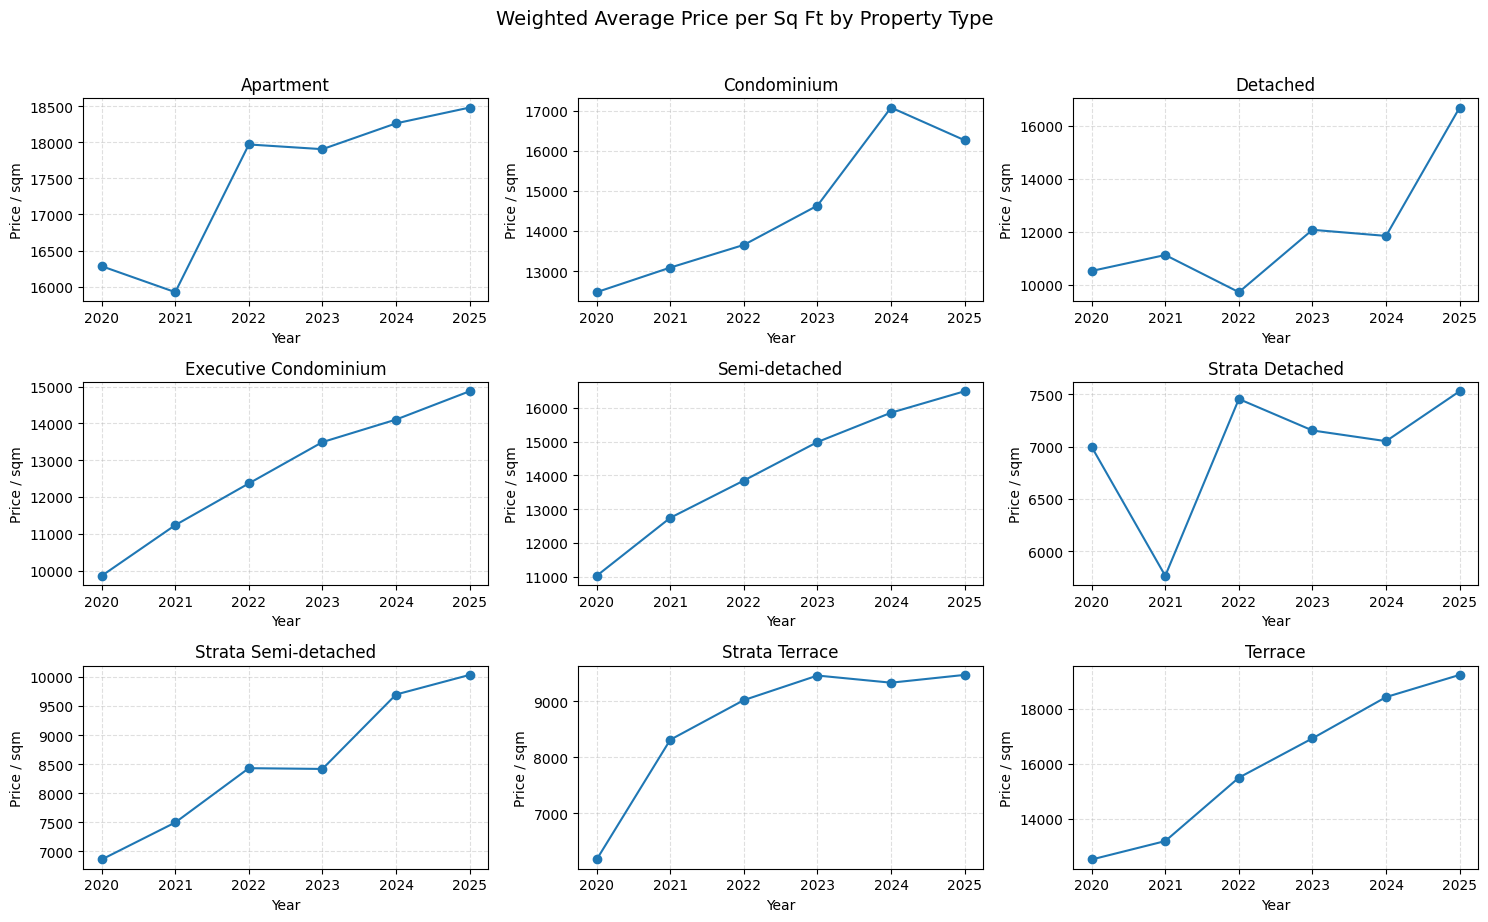

In [27]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_ocr[df_ocr["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["weighted_price_psm"], marker="o", lw=1.5)
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))  # every 1 year
    ax.set_ylabel("Price / sqm")
    ax.grid(True, linestyle="--", alpha=0.4)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Weighted Average Price per Sq Ft by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

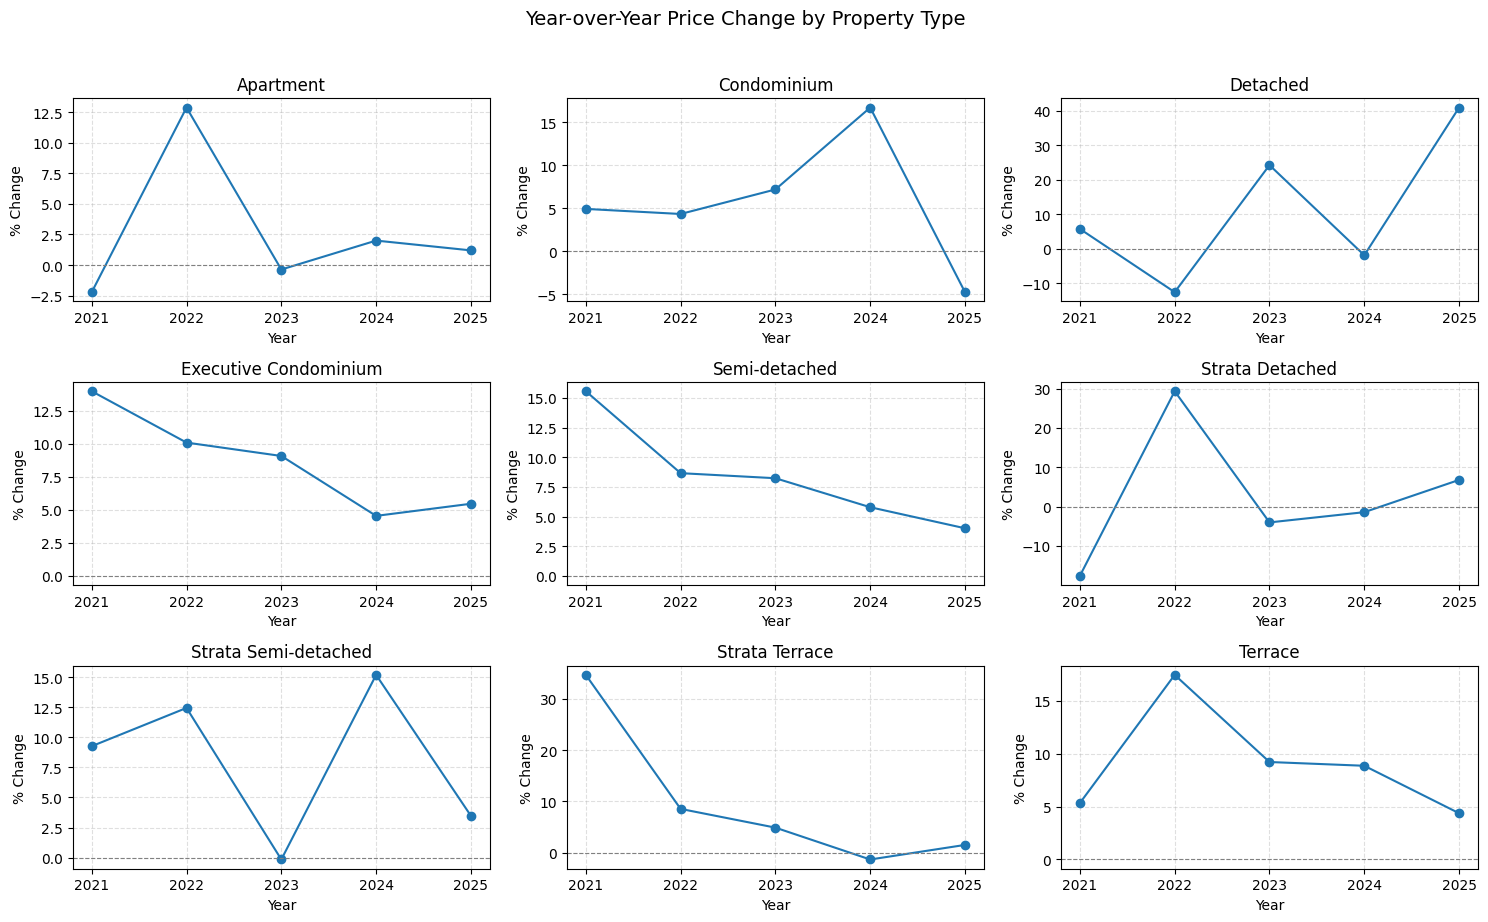

In [28]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_ocr[df_ocr["propertyType"] == ptype]
    ax.plot(subset["contractYear"], subset["pct_change"] * 100, marker="o", lw=1.5)
    ax.axhline(0, color="gray", lw=0.8, linestyle="--")
    ax.set_title(ptype)
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.set_ylabel("% Change")
    ax.grid(True, linestyle="--", alpha=0.4)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year-over-Year Price Change by Property Type", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

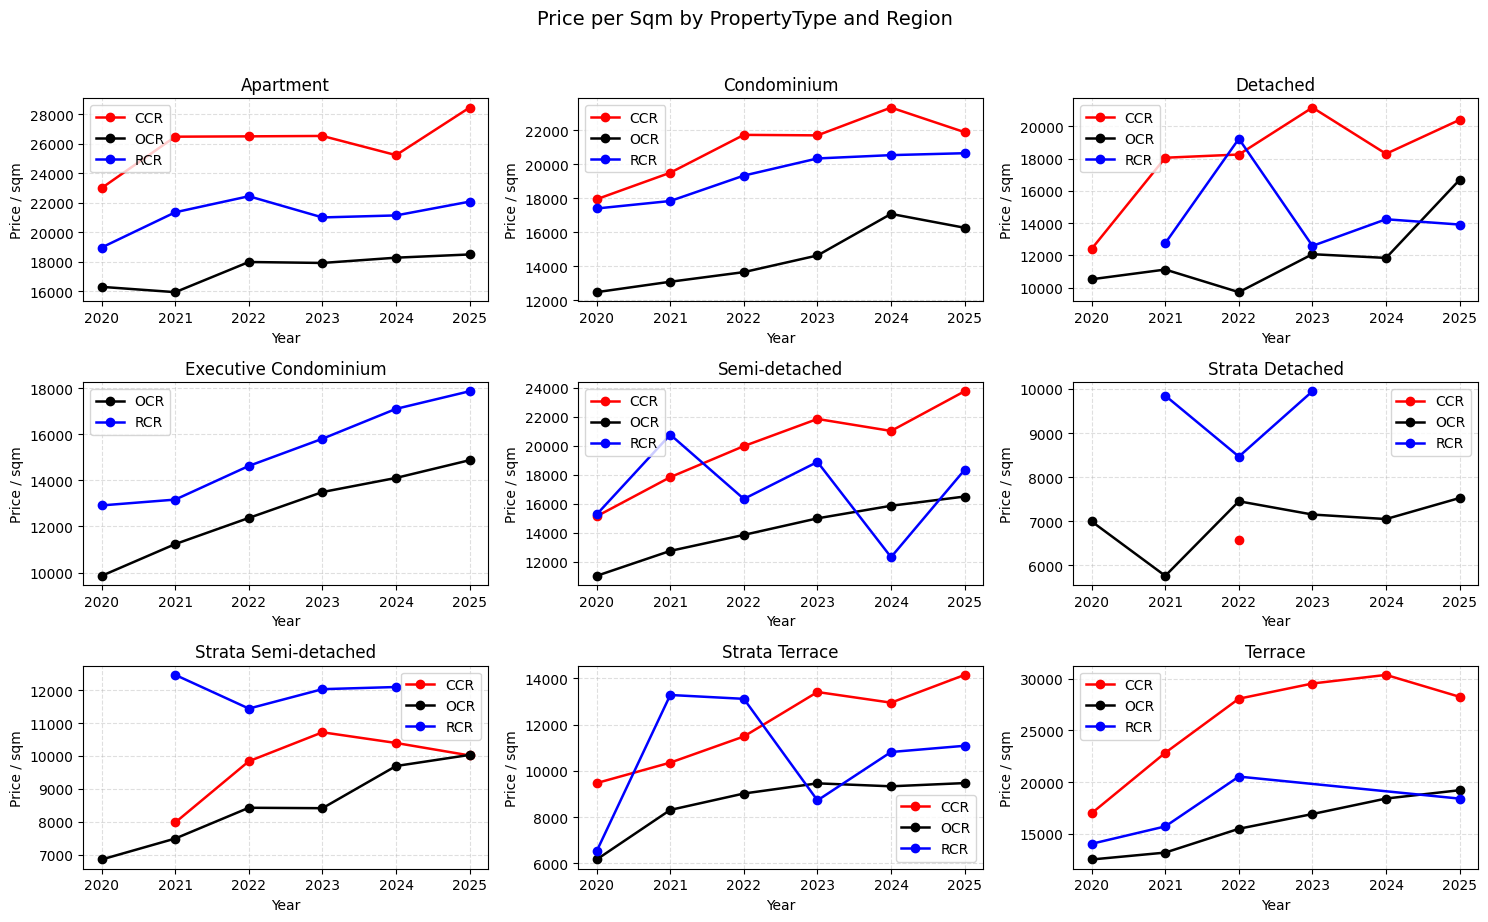

In [29]:
# Define fixed colors for each region
region_colors = {
    "CCR": "red",
    "RCR": "blue",
    "OCR": "black",
}

# Combine all regions
df_all = pd.concat([df_ccr.assign(region="CCR"),
                    df_rcr.assign(region="RCR"),
                    df_ocr.assign(region="OCR")],
                   ignore_index=True)

# Get all unique property_types
property_types = sorted(df_all["propertyType"].unique())
ncols = 3
nrows = math.ceil(len(property_types) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, ptype in enumerate(property_types):
    ax = axes[i]
    subset = df_all[df_all["propertyType"] == ptype]
    
    for region, group in subset.groupby("region"):
        ax.plot(
            group["contractYear"], group["weighted_price_psm"],
            marker="o", lw=1.8,
            label=region,
            color=region_colors.get(region, "gray")  # fallback gray if unknown region
        )
    
    ax.set_title(f"{ptype}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Price / sqm")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Price per Sqm by PropertyType and Region", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## Data Tables

In [30]:
df_ccr.head(n=50)

,propertyType,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,Apartment,2020,22998.032270,163.0,NaN,NaN
1,Apartment,2021,26486.463139,1787.0,0.151684,0.141225
2,Apartment,2022,26509.226306,896.0,0.000859,0.000859
3,Apartment,2023,26536.696456,711.0,0.001036,0.001036
4,Apartment,2024,25233.337441,555.0,-0.049115,-0.050363
5,Apartment,2025,28465.378211,665.0,0.128086,0.120523
6,Condominium,2020,17940.066423,123.0,NaN,NaN
7,Condominium,2021,19500.149214,687.0,0.086961,0.083386
8,Condominium,2022,21725.690679,619.0,0.114129,0.108073
9,Condominium,2023,21697.128223,484.0,-0.001315,-0.001316


In [31]:
summary = (
    df_ccr.groupby("propertyType")
    .agg(
        avg_log_return=("log_return", "mean"),
        volatility=("log_return", "std"),
        total_observations=("log_return", "count"),
        total_transactions=("total_transactions", "sum")
    )
    .reset_index()
)

summary["avg_pct_return"] = np.exp(summary["avg_log_return"]) - 1

summary.head(n=99)

,propertyType,avg_log_return,volatility,total_observations,total_transactions,avg_pct_return
0,Apartment,0.042656,0.083533,5,4777.0,0.043579
1,Condominium,0.039739,0.070935,5,2958.0,0.040539
2,Detached,0.099633,0.191543,5,97.0,0.104766
3,Semi-detached,0.090168,0.076810,5,197.0,0.094359
4,Strata Detached,NaN,NaN,0,1.0,NaN
5,Strata Semi-detached,0.056677,0.116126,4,59.0,0.058314
6,Strata Terrace,0.080199,0.069797,5,138.0,0.083503
7,Terrace,0.101548,0.147197,5,48.0,0.106883


In [32]:
df_rcr.head(n=50)

,propertyType,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,Apartment,2020,18956.593408,804.0,NaN,NaN
1,Apartment,2021,21350.940860,4023.0,0.126307,0.118944
2,Apartment,2022,22439.972303,2206.0,0.051006,0.049748
3,Apartment,2023,20999.580970,969.0,-0.064189,-0.066341
4,Apartment,2024,21136.556535,1065.0,0.006523,0.006502
5,Apartment,2025,22073.727346,908.0,0.044339,0.043384
6,Condominium,2020,17394.630841,690.0,NaN,NaN
7,Condominium,2021,17835.130318,2707.0,0.025324,0.025009
8,Condominium,2022,19330.655136,1986.0,0.083853,0.080522
9,Condominium,2023,20338.734564,1663.0,0.052149,0.050835


In [33]:
summary = (
    df_rcr.groupby("propertyType")
    .agg(
        avg_log_return=("log_return", "mean"),
        volatility=("log_return", "std"),
        total_observations=("log_return", "count"),
        total_transactions=("total_transactions", "sum")
    )
    .reset_index()
)

summary["avg_pct_return"] = np.exp(summary["avg_log_return"]) - 1

summary.head(n=99)

,propertyType,avg_log_return,volatility,total_observations,total_transactions,avg_pct_return
0,Apartment,0.030447,0.067663,5,9975.0,0.030916
1,Condominium,0.034284,0.031377,5,9943.0,0.034878
2,Detached,0.021701,0.347759,4,26.0,0.021938
3,Executive Condominium,0.064969,0.033546,5,42.0,0.067126
4,Semi-detached,0.036732,0.356119,5,42.0,0.037415
5,Strata Detached,0.005064,0.220902,2,6.0,0.005076
6,Strata Semi-detached,-0.009974,0.069118,3,5.0,-0.009924
7,Strata Terrace,0.105784,0.406299,5,141.0,0.111581
8,Terrace,0.090217,0.189310,3,15.0,0.094411


In [34]:
df_ocr.head(n=50)

,propertyType,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,Apartment,2020,16282.596938,1094.0,NaN,NaN
1,Apartment,2021,15922.055201,3674.0,-0.022143,-0.022392
2,Apartment,2022,17971.917444,2739.0,0.128744,0.121105
3,Apartment,2023,17906.598642,1760.0,-0.003634,-0.003641
4,Apartment,2024,18265.030865,1861.0,0.020017,0.019819
5,Apartment,2025,18484.176055,1298.0,0.011998,0.011927
6,Condominium,2020,12472.349490,1626.0,NaN,NaN
7,Condominium,2021,13085.265127,7265.0,0.049142,0.047973
8,Condominium,2022,13651.234125,4555.0,0.043252,0.042343
9,Condominium,2023,14631.292584,3557.0,0.071793,0.069333


In [35]:
summary = (
    df_ocr.groupby("propertyType")
    .agg(
        avg_log_return=("log_return", "mean"),
        volatility=("log_return", "std"),
        total_observations=("log_return", "count"),
        total_transactions=("total_transactions", "sum")
    )
    .reset_index()
)

summary["avg_pct_return"] = np.exp(summary["avg_log_return"]) - 1

summary.head(n=99)

,propertyType,avg_log_return,volatility,total_observations,total_transactions,avg_pct_return
0,Apartment,0.025364,0.055901,5,12426.0,0.025688
1,Condominium,0.053052,0.072634,5,24715.0,0.054485
2,Detached,0.092407,0.189826,5,173.0,0.096811
3,Executive Condominium,0.082325,0.034862,5,13395.0,0.085809
4,Semi-detached,0.080476,0.040036,5,744.0,0.083802
5,Strata Detached,0.014658,0.164897,5,22.0,0.014766
6,Strata Semi-detached,0.075972,0.058951,5,106.0,0.078932
7,Strata Terrace,0.085692,0.123856,5,553.0,0.089470
8,Terrace,0.085635,0.046387,5,1709.0,0.089409


# By Region

In [36]:
print(df['district'].unique())

[ 5  7  4  3  1  2  6 10  9 11 14 12 13  8 15 20 19 17 21 16 18 23 22 27
 26 28 25 24]


In [37]:
def df_by_region(df):
    df_seg = df.copy()
    group_cols = ["project", "street", "district", "area", "x", "y", "typeOfArea", "propertyType", 'tenureStartYear']

    df_seg = df_seg.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
    df_seg = (
        df_seg.groupby(group_cols+["contractYear"])
        .agg(
            mean_price=("price", "mean"),
            transaction_count=("price", "count")
        )
        .reset_index()
    )

    # Take the average price to 2 decimal places
    df_seg["mean_price"] = df_seg["mean_price"].round(2)

    # Normalize prices to per square foot
    df_seg['price_psm'] = df_seg['mean_price'] / df_seg['area']
    df_seg['price_psm'] = df_seg['price_psm'].round(2)
    df_seg.head()

    df_seg = (
        df_seg.groupby(["district", "contractYear"])
        .apply(lambda g: pd.Series({
            "weighted_price_psm": np.average(g["price_psm"], weights=g["transaction_count"]),
            "total_transactions": g["transaction_count"].sum()
        }))
        .reset_index()
        .sort_values(["district", "contractYear"])
    )

    df_seg["pct_change"] = (
        df_seg.groupby("district")["weighted_price_psm"].pct_change()
    )
    df_seg["log_return"] = (
        df_seg.groupby("district")["weighted_price_psm"]
        .transform(lambda x: np.log(x / x.shift(1)))
    )

    return df_seg


## CCR

In [38]:
df_ccr = df[df['marketSegment']=='CCR']
df_district = df_by_region(df_ccr)
df_ccr = df_district.copy()
df_district.head()

C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\659182760.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,district,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,1,2020,22248.404545,55.0,NaN,NaN
1,1,2021,23358.504585,253.0,0.049896,0.048691
2,1,2022,22793.964364,165.0,-0.024169,-0.024465
3,1,2023,21890.813971,136.0,-0.039622,-0.040429
4,1,2024,21931.518193,166.0,0.001859,0.001858


## RCR

In [39]:
df_rcr = df[df['marketSegment']=='RCR']
df_district = df_by_region(df_rcr)
df_rcr = df_district.copy()
df_district.head()

C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\659182760.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,district,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,1,2020,11557.512500,4.0,NaN,NaN
1,1,2021,14463.035600,25.0,0.251397,0.224260
2,1,2022,17776.826000,20.0,0.229121,0.206300
3,1,2023,18106.387778,9.0,0.018539,0.018369
4,1,2024,18066.678500,20.0,-0.002193,-0.002196


## OCR

In [40]:
df_ocr = df[df['marketSegment']=='OCR']
df_district = df_by_region(df_ocr)
df_ocr = df_district.copy()
df_district.head()

C:\Users\Porkc\AppData\Local\Temp\ipykernel_2860\659182760.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,district,contractYear,weighted_price_psm,total_transactions,pct_change,log_return
0,5,2020,16737.427348,592.0,NaN,NaN
1,5,2021,16191.010268,1118.0,-0.032646,-0.033191
2,5,2022,16382.525988,521.0,0.011829,0.011759
3,5,2023,17780.562014,432.0,0.085337,0.081891
4,5,2024,19262.753521,605.0,0.083360,0.080068


## All Districts

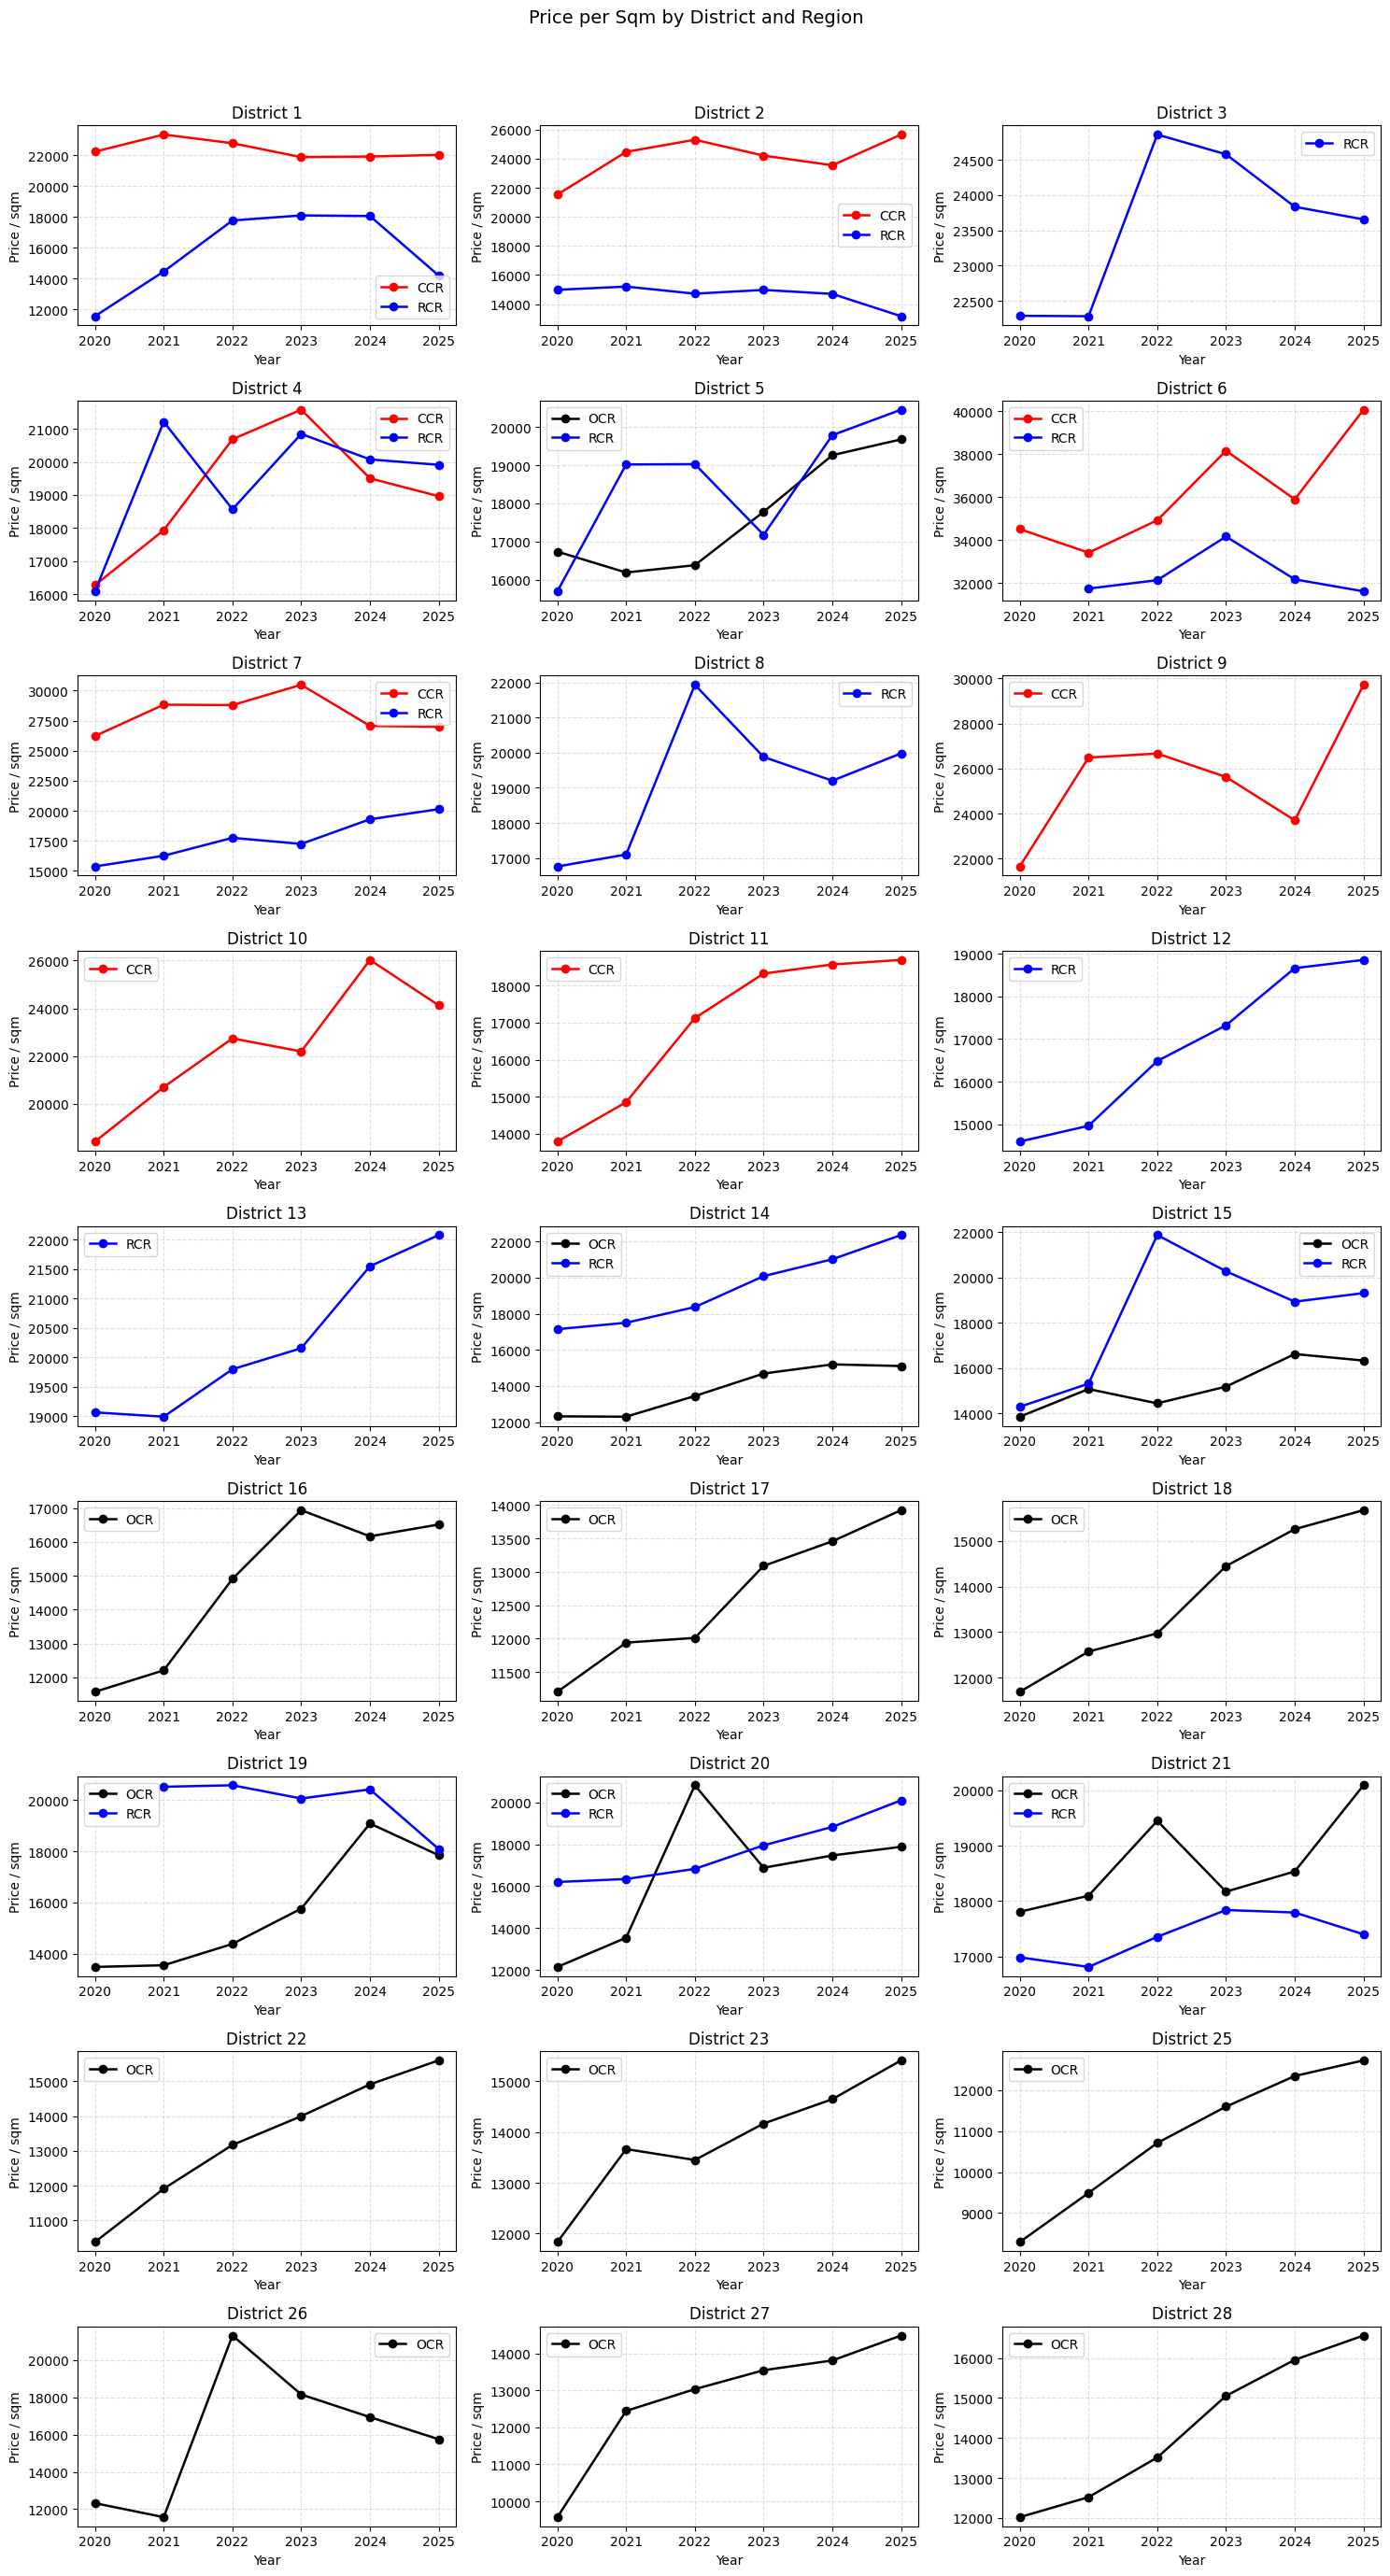

In [41]:
import matplotlib.pyplot as plt
import math

# Define fixed colors for each region
region_colors = {
    "CCR": "red",
    "RCR": "blue",
    "OCR": "black",
}

# Combine all regions
df_all = pd.concat([df_ccr.assign(region="CCR"),
                    df_rcr.assign(region="RCR"),
                    df_ocr.assign(region="OCR")],
                   ignore_index=True)

# Get all unique districts
districts = sorted(df_all["district"].unique())
ncols = 3
nrows = math.ceil(len(districts) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=False)
axes = axes.flatten()

for i, d in enumerate(districts):
    ax = axes[i]
    subset = df_all[df_all["district"] == d]
    
    for region, group in subset.groupby("region"):
        ax.plot(
            group["contractYear"], group["weighted_price_psm"],
            marker="o", lw=1.8,
            label=region,
            color=region_colors.get(region, "gray")  # fallback gray if unknown region
        )
    
    ax.set_title(f"District {d}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Price / sqm")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Price per Sqm by District and Region", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [42]:
df_all.head()

,district,contractYear,weighted_price_psm,total_transactions,pct_change,log_return,region
0,1,2020,22248.404545,55.0,NaN,NaN,CCR
1,1,2021,23358.504585,253.0,0.049896,0.048691,CCR
2,1,2022,22793.964364,165.0,-0.024169,-0.024465,CCR
3,1,2023,21890.813971,136.0,-0.039622,-0.040429,CCR
4,1,2024,21931.518193,166.0,0.001859,0.001858,CCR


In [43]:
# # Select only numeric columns for correlation
# numeric_df = df.select_dtypes(include=['int64', 'float64'])
# non_numeric_df = df.select_dtypes(exclude=['int64', 'float64'])

# print("Numeric columns available:")
# print(numeric_df.columns.tolist())

# print("\nNon-numeric columns available:")
# print(non_numeric_df.columns.tolist())

# # Calculate correlation matrix
# corr = numeric_df.corr()

# # print("\nCorrelation Matrix:")
# # print(corr)

# # Create heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr, 
#             annot=True, 
#             fmt='.2f', 
#             cmap='coolwarm', 
#             center=0,
#             square=True,
#             cbar_kws={"shrink": .8})
# plt.title('Correlation Heatmap (Numeric Variables Only)')
# plt.tight_layout()
# plt.show()